<a href="https://colab.research.google.com/github/mallickboy/stable-diffusion-finetune/blob/main/Inference_loraSDX1_naruto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

OUTPUT_DIR = "/content/drive/MyDrive/naruto_sdxl_lora_output_256"
!mkdir -p $OUTPUT_DIR

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import os
import matplotlib.pyplot as plt
from diffusers import StableDiffusionXLPipeline, AutoencoderKL, EulerAncestralDiscreteScheduler
from PIL import Image

# --- configuration ---
MODEL_NAME = "stabilityai/stable-diffusion-xl-base-1.0"
VAE_MODEL_NAME = "madebyollin/sdxl-vae-fp16-fix"
OUTPUT_DIR = "/content/drive/MyDrive/naruto_sdxl_lora_output_256"
CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, "checkpoint-200")
LORA_WEIGHTS_PATH = os.path.join(CHECKPOINT_DIR, "pytorch_lora_weights.safetensors")

INFER_DIR = os.path.join(OUTPUT_DIR, "inference-2")
os.makedirs(INFER_DIR, exist_ok=True)

NEGATIVE_PROMPT = "low quality, blurry, worst quality, noise, bad anatomy, deformed"
SEED = 42
SCHEDULER = EulerAncestralDiscreteScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")
DTYPE = torch.float16
GENERATOR = torch.Generator("cuda").manual_seed(SEED)


# --- Utility: Initialize Pipeline ---
def _initialize_pipeline(lora_path=None):
    print("Loading VAE with FP16 fix...")
    vae = AutoencoderKL.from_pretrained(VAE_MODEL_NAME, torch_dtype=DTYPE).to("cuda")

    print("Loading SDXL Pipeline (with CPU Offload)...")
    pipe = StableDiffusionXLPipeline.from_pretrained(
        MODEL_NAME,
        vae=vae,
        scheduler=SCHEDULER,
        torch_dtype=DTYPE,
        variant="fp16"
    )
    pipe.enable_model_cpu_offload()
    pipe.enable_vae_tiling()

    if lora_path and os.path.exists(lora_path):
        print(f"Loading LoRA weights from: {lora_path}")
        pipe.load_lora_weights(lora_path)
    elif lora_path:
        print(f"WARNING: LoRA weights not found at: {lora_path}")
    return pipe


In [ ]:
def inf_base(prompts):
    print("Running Base SDXL inference...")
    pipe = _initialize_pipeline(lora_path=None)

    results = []
    for i, prompt in enumerate(prompts, 1):
        GENERATOR.manual_seed(SEED)
        print(f"Generating base image {i}/{len(prompts)}...")
        image = pipe(
            prompt=prompt,
            negative_prompt=NEGATIVE_PROMPT,
            generator=GENERATOR,
            num_inference_steps=30,
            guidance_scale=7.5,
            output_type="pil"
        ).images[0]

        filename = os.path.join(INFER_DIR, f"base_{i+1}_{prompt[:30].replace(' ', '_').replace(',', '')}.png")
        image.save(filename)
        results.append((prompt, filename, image))
        print(f"Saved {filename}")

    # Plot results
    plt.figure(figsize=(15, len(results) * 5))
    for i, (prompt, _, image) in enumerate(results, 1):
        plt.subplot(len(results), 1, i)
        plt.imshow(image)
        plt.axis("off")
        plt.title(prompt, fontsize=12)
    plt.suptitle("Base SDXL Outputs", fontsize=16, y=0.99)
    plt.tight_layout()
    plt.show()

    del pipe
    torch.cuda.empty_cache()

Running Base SDXL inference...
Loading VAE with FP16 fix...
Loading SDXL Pipeline (with CPU Offload)...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generating base image 1/3...


  0%|          | 0/30 [00:00<?, ?it/s]

Saved /content/drive/MyDrive/naruto_sdxl_lora_output_256/inference-2/base_2_Naruto_Uzumaki_eating_ramen&qu.png
Generating base image 2/3...


  0%|          | 0/30 [00:00<?, ?it/s]

Saved /content/drive/MyDrive/naruto_sdxl_lora_output_256/inference-2/base_3_Bill_Gates_in_Naruto_style&quo.png
Generating base image 3/3...


  0%|          | 0/30 [00:00<?, ?it/s]

Saved /content/drive/MyDrive/naruto_sdxl_lora_output_256/inference-2/base_4_A_boy_with_blue_eyes_in_Naruto.png


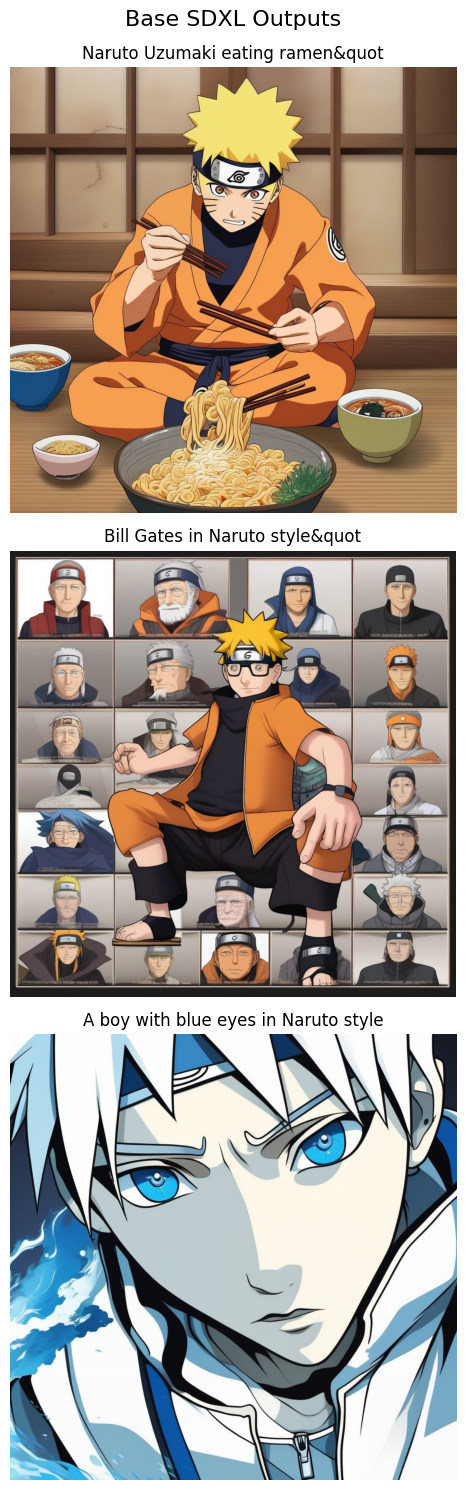

In [ ]:
prompts=[
"Naruto Uzumaki eating ramen&quot",
"Bill Gates in Naruto style&quot",
"A boy with blue eyes in Naruto style",
]
inf_base(prompts)

In [ ]:
def inf_lora(prompts):
    print(f"Running Fine-Tuned LoRA inference with {LORA_WEIGHTS_PATH}...")
    pipe = _initialize_pipeline(lora_path=LORA_WEIGHTS_PATH)

    results = []
    for i, prompt in enumerate(prompts, 1):
        GENERATOR.manual_seed(SEED)
        print(f"Generating LoRA image {i}/{len(prompts)}...")
        image = pipe(
            prompt=prompt,
            negative_prompt=NEGATIVE_PROMPT,
            generator=GENERATOR,
            num_inference_steps=30,
            guidance_scale=7.5,
            output_type="pil"
        ).images[0]

        filename = os.path.join(INFER_DIR, f"lora_{i+1}_{prompt[:30].replace(' ', '_').replace(',', '')}.png")
        image.save(filename)
        results.append((prompt, filename, image))
        print(f"Saved {filename}")

    # Plot results
    plt.figure(figsize=(15, len(results) * 5))
    for i, (prompt, _, image) in enumerate(results, 1):
        plt.subplot(len(results), 1, i)
        plt.imshow(image)
        plt.axis("off")
        plt.title(prompt, fontsize=12)
    plt.suptitle("Fine-Tuned Naruto LoRA Outputs", fontsize=16, y=0.99)
    plt.tight_layout()
    plt.show()

    del pipe
    torch.cuda.empty_cache()

Running Fine-Tuned LoRA inference with /content/drive/MyDrive/naruto_sdxl_lora_output_256/checkpoint-200/pytorch_lora_weights.safetensors...
Loading VAE with FP16 fix...
Loading SDXL Pipeline (with CPU Offload)...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading LoRA weights from: /content/drive/MyDrive/naruto_sdxl_lora_output_256/checkpoint-200/pytorch_lora_weights.safetensors


No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


Generating LoRA image 1/3...


  0%|          | 0/30 [00:00<?, ?it/s]

Saved /content/drive/MyDrive/naruto_sdxl_lora_output_256/inference-2/lora_2_Naruto_Uzumaki_eating_ramen&qu.png
Generating LoRA image 2/3...


  0%|          | 0/30 [00:00<?, ?it/s]

Saved /content/drive/MyDrive/naruto_sdxl_lora_output_256/inference-2/lora_3_Bill_Gates_in_Naruto_style&quo.png
Generating LoRA image 3/3...


  0%|          | 0/30 [00:00<?, ?it/s]

Saved /content/drive/MyDrive/naruto_sdxl_lora_output_256/inference-2/lora_4_A_boy_with_blue_eyes_in_Naruto.png


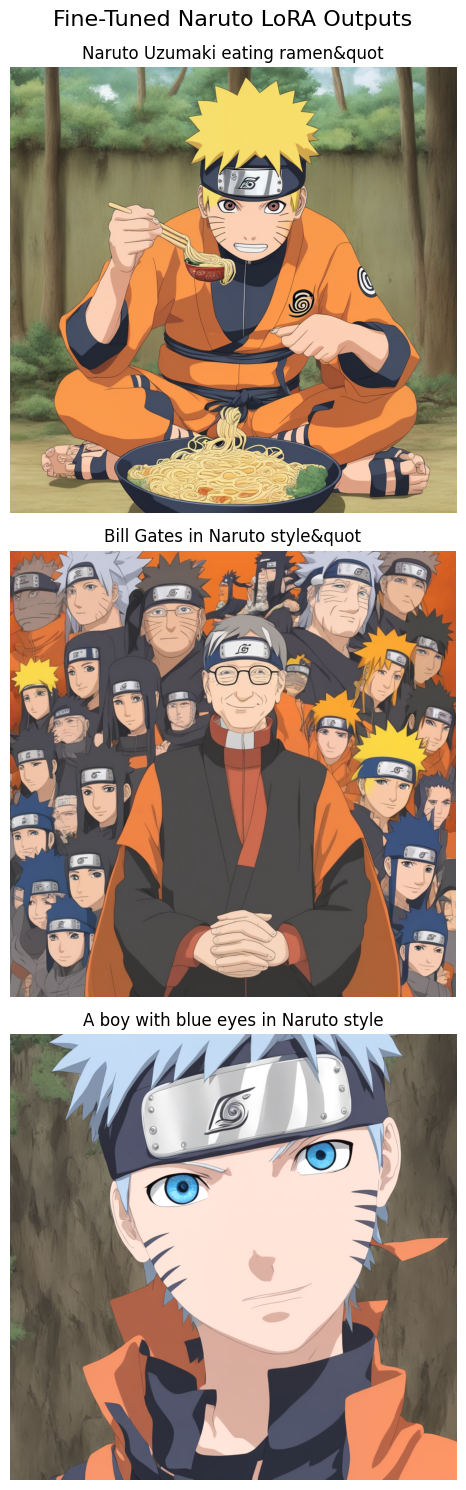

In [ ]:
prompts=[
"Naruto Uzumaki eating ramen&quot",
"Bill Gates in Naruto style&quot",
"A boy with blue eyes in Naruto style",
]
inf_lora(prompts)

#Inference & comparison

### Load drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from inference import LoraInference
lri= LoraInference()

In [ ]:
prompts = [
        "Naruto Uzumaki eating ramen",
        "Bill Gates in Naruto style",
        "A boy with blue eyes in Naruto style",
    ]

In [ ]:
lri1= LoraInference()
base_pipe = lri1.init_pipe()

lri2= LoraInference()
ckpt_pipe = lri2.init_pipe("/content/drive/MyDrive/naruto_sdxl_lora_output/checkpoint-600/pytorch_lora_weights.safetensors")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


In [ ]:
DIR = "/content/drive/MyDrive/naruto_sdxl_lora_output/inference"

In [ ]:
ckpt_res= lri1.inference(ckpt_pipe, prompts, save= DIR+"/1024/lora")

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
base_res= lri2.inference(base_pipe, prompts, save= DIR+"/1024/base")

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
import gc
gc.collect()

0

In [ ]:
# lri2.compare_results(base_res, ckpt_res, save= DIR+"/1024/comp") # OOM ram

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def compare_image_dirs(dir1, dir2, title1="Base Model", title2="LoRA Model", save=None):
    imgs1 = {os.path.basename(f): os.path.join(dir1, f) for f in os.listdir(dir1) if f.lower().endswith((".png", ".jpg", ".jpeg"))}
    imgs2 = {os.path.basename(f): os.path.join(dir2, f) for f in os.listdir(dir2) if f.lower().endswith((".png", ".jpg", ".jpeg"))}
    common = sorted(set(imgs1.keys()) & set(imgs2.keys()))
    if not common:
        print("No matching filenames found.")
        return
    plt.figure(figsize=(10, len(common) * 5))
    for i, name in enumerate(common, 1):
        img1 = Image.open(imgs1[name])
        img2 = Image.open(imgs2[name])
        plt.subplot(len(common), 2, (i * 2) - 1)
        plt.imshow(img1)
        plt.axis("off")
        plt.title(f"{title1}\n{name}", fontsize=10)
        plt.subplot(len(common), 2, i * 2)
        plt.imshow(img2)
        plt.axis("off")
        plt.title(f"{title2}\n{name}", fontsize=10)
    plt.tight_layout()
    if save:
        os.makedirs(os.path.dirname(save), exist_ok=True)
        plt.savefig(save)
        print(f"Saved comparison at: {save}")
    plt.show()

# Base vs Lora 1024

Saved comparison at: /content/drive/MyDrive/naruto_sdxl_lora_output/inference/1024/comp


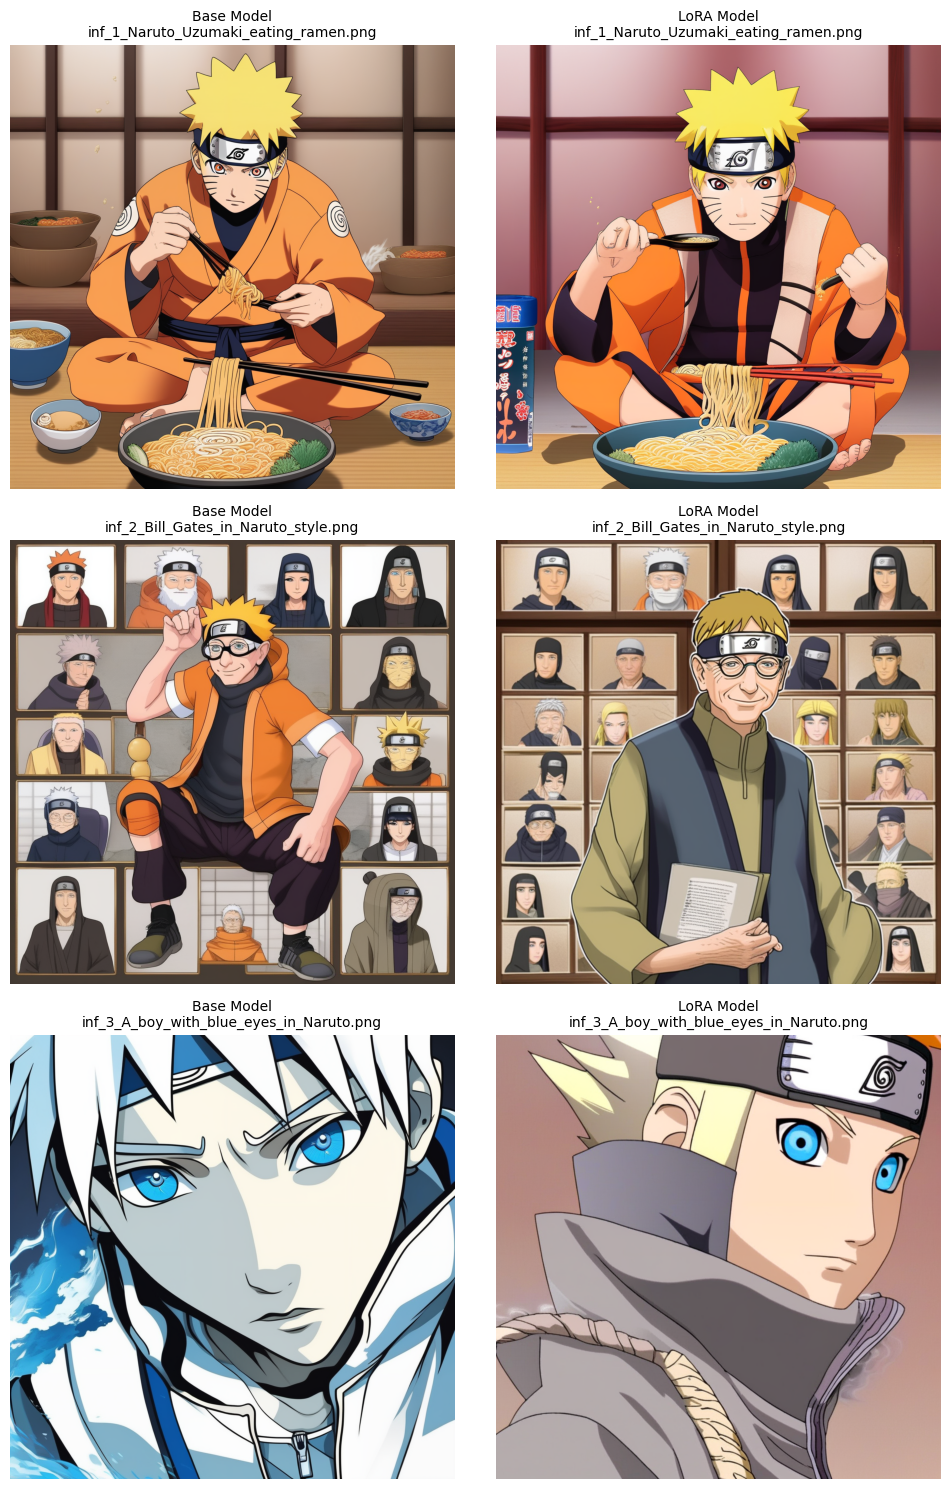

In [ ]:
compare_image_dirs(
    dir1= DIR+"/1024/base",
    dir2= DIR+"/1024/lora",
    save= DIR+"/1024/comp"
)

## Compare resolution 256 vs 1024 model

In [ ]:
from inference import LoraInference
lri3= LoraInference()
ckpt_pipe_256 = lri3.init_pipe("/content/drive/MyDrive/naruto_sdxl_lora_output_256/checkpoint-200/pytorch_lora_weights.safetensors")
ckpt_res_256= lri3.inference(ckpt_pipe_256, prompts, save= DIR+"/256/lora")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Saved comparison at: /content/drive/MyDrive/naruto_sdxl_lora_output/inference/1024vs256


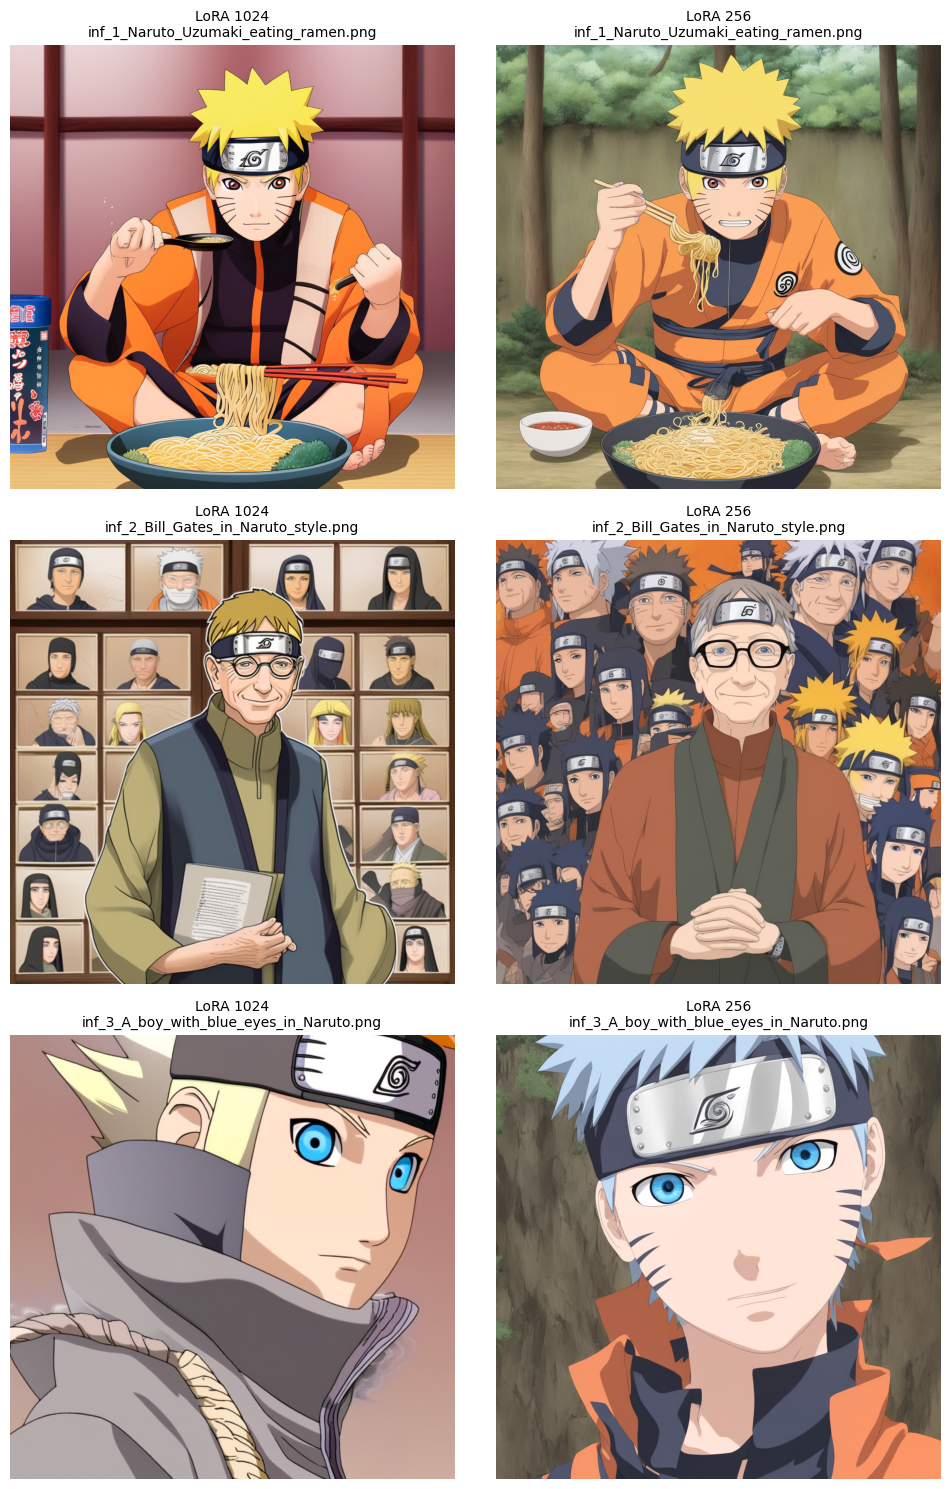

In [ ]:
compare_image_dirs(
    dir1= DIR+"/1024/lora",
    dir2= DIR+"/256/lora",
    title1="LoRA 1024",
    title2="LoRA 256",
    save= DIR+"/1024vs256"
)